In [288]:
#load and plot dataset
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np



In [289]:
series = pd.read_csv('sales-of-shampoo-over-a-three-ye.csv',
                    header=0)
series = series.drop(36) # last line is not a valid data
series['Month'] = series.Month.map(lambda x:pd.datetime.strptime('200'+str(x),'%Y-%m'))
series.columns = ['month','labels']
series.index = series.month
series = series.drop('month', axis=1)

In [290]:
# transform data to be stationary
raw_values = series.values
differenced = series.diff()[1:]
differenced

,labels
month,
2001-02-01,-120.1
2001-03-01,37.2
2001-04-01,-63.8
2001-05-01,61.0
2001-06-01,-11.8
2001-07-01,63.3
2001-08-01,-7.3
2001-09-01,-31.7
2001-10-01,-69.9


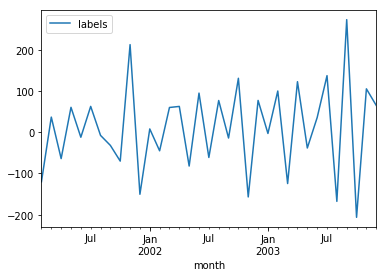

In [291]:
differenced.plot()

In [292]:
sales = differenced.shift().fillna(0)
sales.columns = ['sales']
supervised = pd.concat((differenced,sales), axis=1)

supervised = supervised[['sales','labels']]

In [293]:
supervised_values = supervised.values
supervised.head()

,sales,labels
month,,
2001-02-01,0.0,-120.1
2001-03-01,-120.1,37.2
2001-04-01,37.2,-63.8
2001-05-01,-63.8,61.0
2001-06-01,61.0,-11.8


In [294]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
train

array([[   0. , -120.1],
       [-120.1,   37.2],
       [  37.2,  -63.8],
       [ -63.8,   61. ],
       [  61. ,  -11.8],
       [ -11.8,   63.3],
       [  63.3,   -7.3],
       [  -7.3,  -31.7],
       [ -31.7,  -69.9],
       [ -69.9,  213.6],
       [ 213.6, -150.6],
       [-150.6,    8.4],
       [   8.4,  -44.8],
       [ -44.8,   60.6],
       [  60.6,   63.2],
       [  63.2,  -81.9],
       [ -81.9,   95.6],
       [  95.6,  -61. ],
       [ -61. ,   77.6],
       [  77.6,  -13.7],
       [ -13.7,  131.7],
       [ 131.7, -157.1],
       [-157.1,   77.8]])

In [295]:
test

array([[  77.8,   -2.6],
       [  -2.6,  100.7],
       [ 100.7, -124.5],
       [-124.5,  123.4],
       [ 123.4,  -38. ],
       [ -38. ,   36.1],
       [  36.1,  138.1],
       [ 138.1, -167.9],
       [-167.9,  274.4],
       [ 274.4, -206.7],
       [-206.7,  106. ],
       [ 106. ,   65.6]])

In [296]:
# scale train and test data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train)
#transform train
train = train.reshape(train.shape[0], train.shape[1])
train_scaled = scaler.transform(train)
# transform test
test = test.reshape(test.shape[0], test.shape[1])
test_scaled = scaler.transform(test)

In [297]:
test_scaled

array([[ 0.26733207, -0.16644187],
       [-0.16644187,  0.39088211],
       [ 0.39088211, -0.82411654],
       [-0.82411654,  0.51335312],
       [ 0.51335312, -0.35743189],
       [-0.35743189,  0.04235231],
       [ 0.04235231,  0.59266253],
       [ 0.59266253, -1.05826814],
       [-1.05826814,  1.32802806],
       [ 1.32802806, -1.26760183],
       [-1.26760183,  0.41947667],
       [ 0.41947667,  0.20151066]])

In [298]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        if i%100 == 0:
            print('Epoch #',i)
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [314]:
b = train_scaled[:, -1]
b.shape


(23,)

In [315]:
a = train_scaled[:, 0:-1]

a = a.reshape(a.shape[0],1,a.shape[1])
a.shape

(23, 1, 1)

In [299]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [300]:
#fit the model
lstm_model = fit_lstm(train=train_scaled,
                     batch_size=1,
                     nb_epoch=3000,
                     neurons=4)

Epoch # 0
Epoch # 100
Epoch # 200
Epoch # 300
Epoch # 400
Epoch # 500
Epoch # 600
Epoch # 700
Epoch # 800
Epoch # 900
Epoch # 1000
Epoch # 1100
Epoch # 1200
Epoch # 1300
Epoch # 1400
Epoch # 1500
Epoch # 1600
Epoch # 1700
Epoch # 1800
Epoch # 1900
Epoch # 2000
Epoch # 2100
Epoch # 2200
Epoch # 2300
Epoch # 2400
Epoch # 2500
Epoch # 2600
Epoch # 2700
Epoch # 2800
Epoch # 2900


In [301]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:,0].reshape(len(train_scaled),1,1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.79802603],
       [ 0.05212063],
       [-0.49011129],
       [ 0.17829794],
       [-0.20455612],
       [ 0.08432364],
       [-0.24166255],
       [ 0.03613856],
       [ 0.15711179],
       [ 0.25735039],
       [-1.09219432],
       [ 0.22369611],
       [ 0.05363801],
       [ 0.19072786],
       [-0.2421075 ],
       [-0.37715286],
       [ 0.18259466],
       [-0.44786218],
       [ 0.13970301],
       [-0.35661495],
       [ 0.02811706],
       [-0.69375098],
       [ 0.28406924]], dtype=float32)

In [302]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    #yhat = y
    # invert scaling and forecasting
    yhat = (scaler.inverse_transform([X[0],yhat]))[1] + raw_values[len(train)+i]
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=310.592776, Expected=339.700000
Month=2, Predicted=363.198734, Expected=440.400000
Month=3, Predicted=369.956831, Expected=315.900000
Month=4, Predicted=389.474247, Expected=439.300000
Month=5, Predicted=357.847545, Expected=401.300000
Month=6, Predicted=443.535663, Expected=437.400000
Month=7, Predicted=440.121123, Expected=575.500000
Month=8, Predicted=460.181674, Expected=407.600000
Month=9, Predicted=489.827761, Expected=682.000000
Month=10, Predicted=442.891795, Expected=475.300000
Month=11, Predicted=555.827351, Expected=581.300000
Month=12, Predicted=518.561186, Expected=646.900000


c:\program files\python35\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\program files\python35\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\program files\python35\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single 

Test RMSE: 86.761


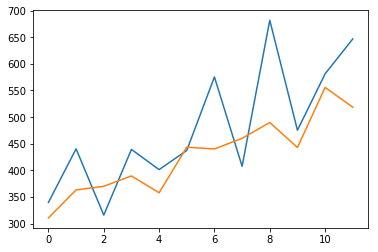

In [303]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(raw_values[-12:])
plt.plot(predictions)